In [1]:
%matplotlib nbagg

#visualizations
import matplotlib 
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn
#core imports
import numpy as np
import math
from scipy.stats import norm
from sklearn.neighbors import KDTree

#NN
import tensorflow as tf

In [2]:
#NP core
from npfunc import loglikelihood1, loglikelihood2, loglikelihood3, KLqp_gauss, distBD
from npfunc import posterior_predict, prior_predict, init_NP
#optimization
from npopt import np_iteration, sample_curves
#plotting
from npplot import plot_np_fit_1D

In [3]:
#network parameters
dim_r = 16
dim_z = 16
dim_h_hidden = [128, 64, 32]
dim_g_hidden = [128, 64, 32]

In [4]:
#create placeholders for the data
x_context = tf.placeholder(tf.float32, shape=(None, 1))
y_context = tf.placeholder(tf.float32, shape=(None, 1))
x_target = tf.placeholder(tf.float32, shape=(None, 1))
y_target = tf.placeholder(tf.float32, shape=(None, 1))

In [5]:
#define gaussian activation function 
def g_act(x):
    return tf.exp(tf.negative( tf.square(x) ) )

In [6]:
#define training operation and loss function
noise_sd = 0.1
activation_function = g_act#tf.nn.tanh
train_op_and_loss = init_NP(x_context, y_context, x_target, y_target, 
                            dim_h_hidden, dim_g_hidden, dim_r, dim_z, 
                            loglikelihood2, noise_sd = noise_sd, lr= 0.001, act_f=activation_function)

In [7]:
#create interactive session
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)

In [8]:
#define a function to predict 
def f(x):
    """The function to predict."""
    #return x * np.sin(x)
    return x*x * np.sin(x)
    #return np.sin(2*x) - np.abs(x/2) #+ np.random.normal(scale=0.1)

In [9]:
#range for predictions and true values
n_t = 100
x_t = np.atleast_2d(np.linspace(-5, 17, n_t)).T.astype(np.float32)
y_t = f(x_t).astype(np.float32)

In [13]:
#initialize random point and compute its value
#x_0 = np.random.randint(low=0, high=x_t.shape[0], size=3)
x_0 = [ 0, np.random.randint(low=0, high=x_t.shape[0]), x_t.shape[0] - 1]
x_data = x_t[x_0]
y_data = y_t[x_0]

In [14]:
x_data

array([[-5.       ],
       [ 7.2222223],
       [17.       ]], dtype=float32)

<IPython.core.display.Javascript object>


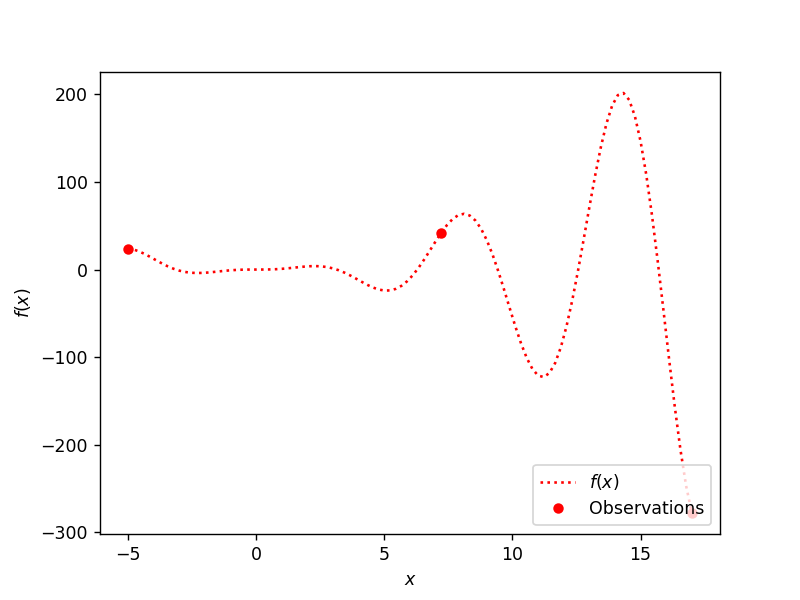

In [15]:
#plot the function
fig = plt.figure()
plt.plot(x_t, y_t, 'r:', label=u'$f(x)$')
plt.plot(x_data, y_data, 'r.', markersize=10, label=u'Observations')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='lower right')

In [16]:
#save the history 
y_history_mean = np.zeros(shape = (0, n_t))
y_history_sigma = np.zeros(shape = (0, n_t))

In [17]:
#number of points to compute 
n_points = 20
#number of training steps at each point and how often to print loss
n_steps = 10000
p_freq = 2000 
#number of samples from latent variable space
n_draws = 1000

for p in range(n_points): 
    print("Point: ", p)
    #train NP
    for i in range(n_steps):

        #perform 1 np iteration 
        a = np_iteration(x_data, y_data, x_context, y_context, 
                         x_target, y_target, sess, train_op_and_loss)

        #print iteration and loss
        if(i % p_freq == 0):
            print(i, a[1])
    
    print(i, a[1])
    #compute mean and std of the samples
    y_star_mat, y_star_mean, y_star_sigma = sample_curves(x_data, y_data, x_t, 
                                            dim_h_hidden, dim_g_hidden, dim_r, dim_z,
                                            sess, epsilon_std=5.0, n_draws=n_draws, act_f=activation_function)
    
    print("Current maximum: ", np.amax(y_star_mean), ' at: ', x_t[np.argmax(y_star_mean)])
    
    #save the values in history 
    y_history_mean = np.append(y_history_mean, np.atleast_2d(y_star_mean), axis=0)
    y_history_sigma = np.append(y_history_sigma, np.atleast_2d(y_star_sigma), axis=0)

    
    #predict values of the observed data
    predict_op2 = posterior_predict(x_data, y_data, x_data, dim_h_hidden, dim_g_hidden, dim_r, dim_z, epsilon=None, n_draws=1, act_f=activation_function)
    y_star_mat2 = sess.run(predict_op2)
    #y_star_std2 = np.sqrt(np.mean(y_star_mat[1], axis=1) + 1e-16)
    
    #compute objective function
    imp = y_star_mean - np.amax(y_star_mean) - 0.01
    Z = imp / (y_star_sigma + 1e-16)
    ei = imp * norm.cdf(Z)  + y_star_sigma * norm.pdf(Z)
        
    x_data_new = np.atleast_2d(np.array(x_t[np.argmax(ei)]))
    y_data_new = np.atleast_2d(np.array(y_t[np.argmax(ei)]))
    print("Evaluating at maximum acquisition function: ", x_data_new)

    #if already evaluated 
    if np.any(np.isclose(x_data_new, x_data)):
        
        #choose maximum curve family uncertainty
        sc_unc = (y_star_sigma *np.power(np.abs(((x_t - x_data[-1])/ (np.max(x_t) - np.min(x_t)))), 0.5).T)
        x_data_new = np.atleast_2d(np.array(x_t[np.argmax(sc_unc)])).astype(np.float32)
        y_data_new = np.atleast_2d(np.array(y_t[np.argmax(sc_unc)]))
        #x_data_new = np.atleast_2d(np.array(x_t[np.argmax(y_star_sigma)])).astype(np.float32)
        #y_data_new = np.atleast_2d(np.array(y_t[np.argmax(y_star_sigma)]))
        print("Already done, evaluating at most uncertainty: ", x_data_new)
#         x_data_new = np.atleast_2d(np.array(x_t[np.argmax(y_star_mean)])).astype(np.float32)
#         y_data_new = np.atleast_2d(np.array(y_t[np.argmax(y_star_mean)]))
#         print("Evaluating at maximum: ", x_data_new)
        
        #or choose a random point
        if np.any(np.isclose(x_data_new, x_data)):
            rp = np.random.randint(low = 0, high = x_t.shape[0])
            x_data_new = np.atleast_2d(np.array(x_t[rp])).astype(np.float32)
            y_data_new = np.atleast_2d(np.array(y_t[rp]))
            print("Already done, evaluating at random point: ", x_data_new)

    x_data = np.append(x_data, x_data_new, axis=0)
    y_data = np.append(y_data, y_data_new, axis=0)

Point:  0
0 3887190.8
2000 3256536.0
4000 2782648.8
6000 -0.8518176
8000 0.82504666
9999 16.043839
Current maximum:  41.31333  at:  [7.2222223]
Evaluating at maximum acquisition function:  [[7.4444447]]
Point:  1
0 3271.6267
2000 431016.38
4000 1003074.3
6000 -0.8627156
8000 175669.05
9999 6.210714
Current maximum:  50.07299  at:  [7.4444447]
Evaluating at maximum acquisition function:  [[7.4444447]]
Already done, evaluating at most uncertainty:  [[-4.111111]]
Point:  2
0 13379.714
2000 0.024687432
4000 29325.023
6000 -1.1896367
8000 -0.08736276
9999 -1.2107469
Current maximum:  50.70888  at:  [7.4444447]
Evaluating at maximum acquisition function:  [[7.4444447]]
Already done, evaluating at most uncertainty:  [[4.3333335]]
Point:  3
0 471.43338
2000 0.5020144
4000 -1.3168168
6000 -0.9930654
8000 -1.3559749
9999 -1.3381876
Current maximum:  50.770542  at:  [7.4444447]
Evaluating at maximum acquisition function:  [[7.4444447]]
Already done, evaluating at most uncertainty:  [[-2.7777777]]

In [18]:
x_t[np.argmax(y_t)]

array([14.333333], dtype=float32)

<IPython.core.display.Javascript object>


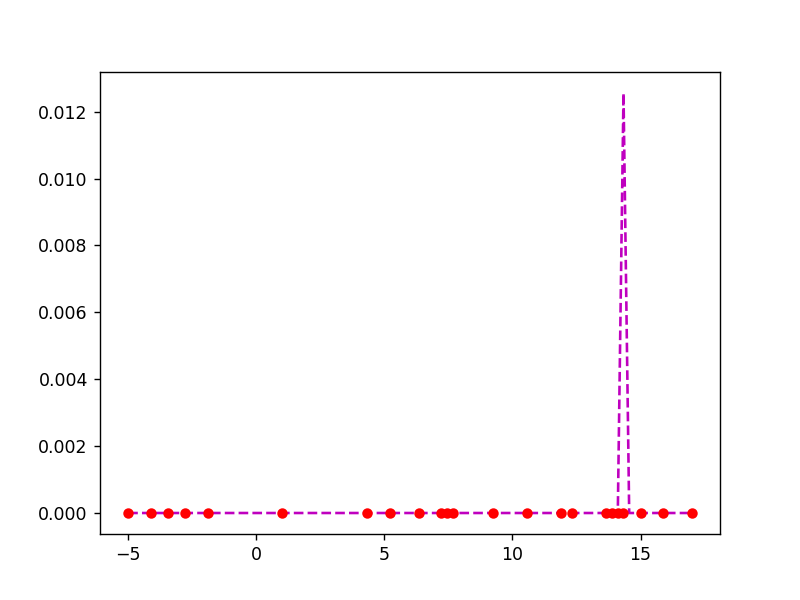

In [19]:
#plot the acquisition function 
fig = plt.figure()
plt.plot(x_t,  ei , 'm--')
plt.plot(x_data, np.zeros_like(x_data), 'r.', markersize=10, label=u'Observations')

<IPython.core.display.Javascript object>


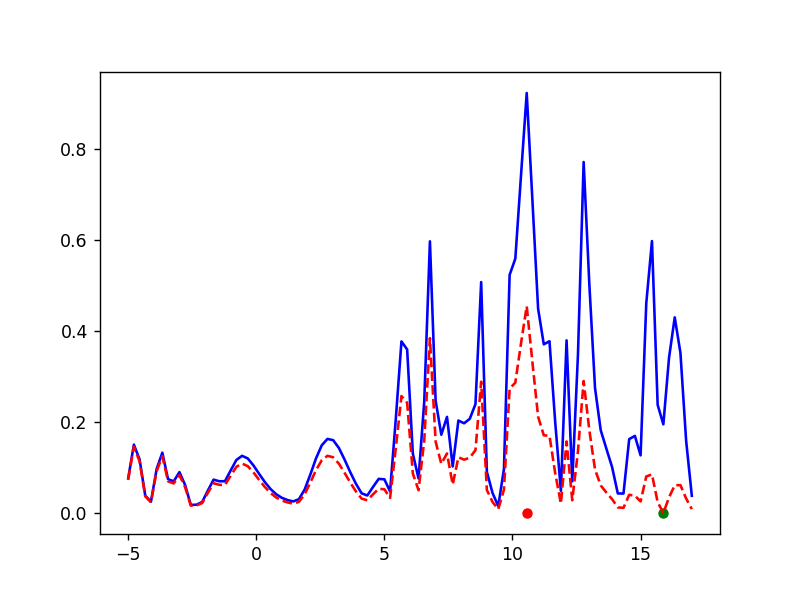

In [20]:
#we can look at std from generated curves 
fig = plt.figure()
plt.plot(x_t, y_star_sigma, 'b-')
plt.plot(x_data[-2], 0, 'g.', markersize=10, label=u'Last point')
plt.plot(x_data_new, 0, 'r.', markersize=10, label=u'Next point')
plt.plot(x_t, (y_star_sigma *np.power(np.abs(((x_t - x_data[-2])/ (np.max(x_t) - np.min(x_t)))), 0.5).T).T  , 'r--')

<IPython.core.display.Javascript object>


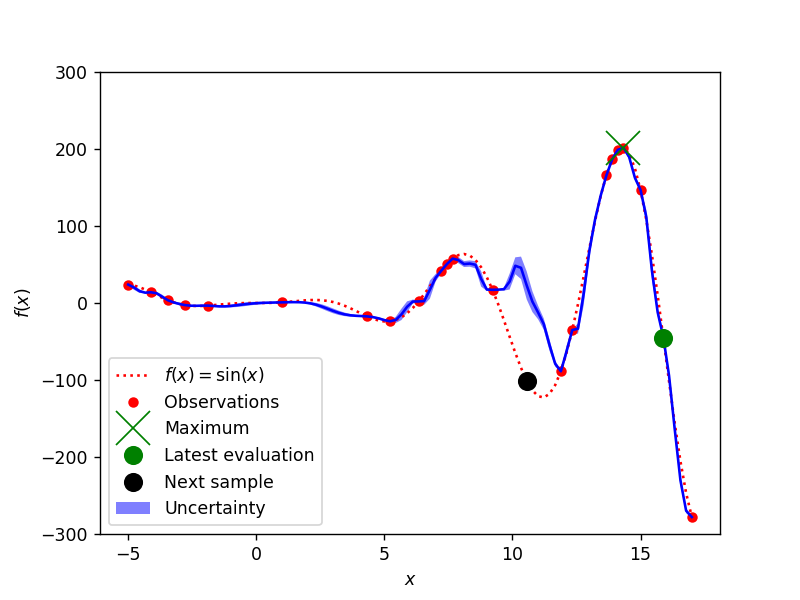

In [21]:
#plot the final fit 
fig1 = plot_np_fit_1D(x_t, y_t, x_data, y_data, y_star_mean, y_star_sigma, 10, ylim=(-300,300), lloc = "lower left", fignum=10)

<IPython.core.display.Javascript object>


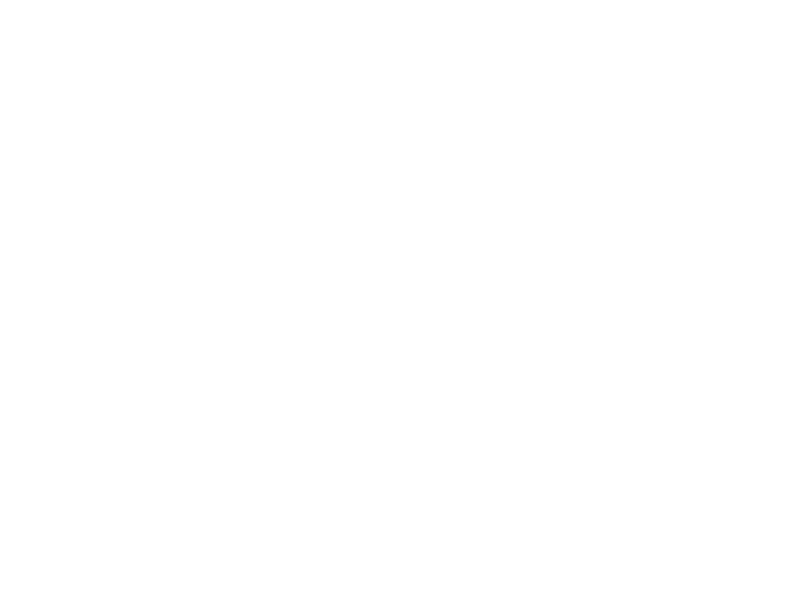

In [28]:
#plot the history 
n_iter = y_history_mean.shape[0]
n_start = 3
path = "./Figures/1D-test1/"
fname = "test_"
unc_scale = 1.0

for i in range(n_iter):
    fig1 = plot_np_fit_1D(x_t, y_t, x_data[0:i+ n_start+1], y_data[0:i+ n_start+1], 
                          y_history_mean[i], y_history_sigma[i], 
                          unc_scale, ylim=(-300,300), lloc = "lower left", fignum=20)
    fig1.savefig(path + fname + str(i) + '.png')
    fig1.clear()
    #plt.close(fig1)

In [ ]:
sess.close()